NVIDIA A100-SXM-80GB: 108 SMs, 2039 GBps, 40.0 MB L2

v0
GBps:  23 ms:  0.006 MB:    0.06, dim: (        1,    16384) axis:0 max_err:    0.000 max_val:    1.000 l2_err: 0.00000
GBps:  45 ms:  0.006 MB:    0.12, dim: (        1,    32768) axis:0 max_err:    0.000 max_val:    1.000 l2_err: 0.00000
GBps:  91 ms:  0.006 MB:    0.25, dim: (        1,    65536) axis:0 max_err:    0.000 max_val:    1.000 l2_err: 0.00000
GBps: 182 ms:  0.006 MB:    0.50, dim: (        1,   131072) axis:0 max_err:    0.000 max_val:    1.000 l2_err: 0.00000
GBps: 367 ms:  0.006 MB:    1.00, dim: (        1,   262144) axis:0 max_err:    0.000 max_val:    1.000 l2_err: 0.00000
GBps: 606 ms:  0.007 MB:    2.00, dim: (        1,   524288) axis:0 max_err:    0.000 max_val:    1.000 l2_err: 0.00000
GBps: 875 ms:  0.010 MB:    4.00, dim: (        1,  1048576) axis:0 max_err:    0.000 max_val:    1.000 l2_err: 0.00000
GBps:1154 ms:  0.015 MB:    8.00, dim: (        1,  2097152) axis:0 max_err:    0.000 max_val:    1.000

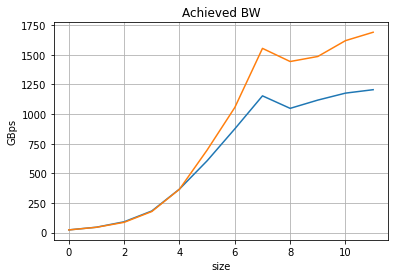

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

import pycuda.driver as drv
import pycuda.autoinit
from pycuda.compiler import SourceModule
from pycuda.autoinit import context, device

file_path = os.getcwd()
attributes = drv.Context.get_device().get_attributes()
sms = attributes[drv.device_attribute.MULTIPROCESSOR_COUNT]
mcr = attributes[drv.device_attribute.MEMORY_CLOCK_RATE]
bus = attributes[drv.device_attribute.GLOBAL_MEMORY_BUS_WIDTH]
l2s = attributes[drv.device_attribute.L2_CACHE_SIZE]

print(f"{device.name()}: {sms} SMs, {mcr*1000*bus*2*1e-9/8:.0f} GBps, {l2s/1024**2:.1f} MB L2\n")

def ceil_div(x, y):
    return -(-x // y)

# simplest possible
def copy_v0(Y, X, dim):
    code = r"""
extern "C"
__global__ void copy_v0(float* __restrict__ Y,
                        float* __restrict__ X,
                        const int dim0, const int dim1)
{
    int N = dim0 * dim1;
    int tid = threadIdx.x + blockIdx.x * blockDim.x;
    if (tid < N) {
        Y[tid] = X[tid];
    }
}
"""
    sig    = "PPII"
    threads = 256
    blocks = ceil_div(dim[1], threads)
    grid   = (blocks, dim[0], 1)
    block  = (threads, 1, 1)
    params = (Y, X, dim[0], dim[1])
    
    func = get_kernel("copy_v0", code, sig, grid, block, params)

    return func

# float4
def copy_v1(Y, X, dim):
    code = r"""
extern "C"
__global__ void copy_v1(float4* __restrict__ Y,
                        float4* __restrict__ X,
                        const int dim0, const int dim1)
{
    int N = dim0 * dim1;
    int tid = threadIdx.x + blockIdx.x * blockDim.x;
    if (tid < N) {
        Y[tid] = X[tid];
    }
}
"""
    sig    = "PPII"
    threads = 256
    blocks = ceil_div(dim[1]//4, threads)
    grid   = (blocks, dim[0], 1)
    block  = (threads, 1, 1)
    params = (Y, X, dim[0], dim[1])
    
    func = get_kernel("copy_v1", code, sig, grid, block, params)

    return func



def get_kernel(name, code, sig, grid, block, params):

    # you might find it easier to develop the cuda code in separate files
    if code[-3:] == ".cu":
        with open(code) as file:
            code = file.read()

    module = SourceModule(code, include_dirs=[file_path], no_extern_c=True)
    kernel = module.get_function(name)
    kernel.prepare(sig)

    def func():
        kernel.prepared_call(grid, block, *params)

    return func

kernels = {'v0': copy_v0,
           'v1': copy_v1}
                 
def test_axpy(dim, axis, repeat=1, ones=False, out=False, kernel='v0'):
    
    if ones:
        x = np.ones(dim, dtype=np.float32)
    else:
        x = np.random.uniform(-1.0, 1.0, dim).astype(np.float32)
    
    y = np.empty(dim[1-axis], dtype=np.float32)
    
    X = drv.mem_alloc(x.nbytes)
    Y = drv.mem_alloc(y.nbytes)
    drv.memcpy_htod(X, x)
    
    kernel_func = kernels[kernel]
    
    gpu_func = kernel_func(Y, X, dim)
    
    start = drv.Event()
    end   = drv.Event()
    
    for r in range(repeat):
        gpu_func() # warm up the clock
        
    start.record()
    for r in range(repeat):
        gpu_func()
        
    end.record()
    end.synchronize()

    # compute the approximate memory bandwidth
    nbytes = y.nbytes + x.nbytes
    ms     = end.time_since(start) / repeat
    gbps   = nbytes / (ms * 1e6)

    drv.memcpy_dtoh(y, Y)
    #z = np.sum(x.astype(np.float64), axis=axis).astype(np.float32)
    z = np.copy(x)
    if out:
        print(f'{x=}')
        print(f'{y=}')
    d = np.abs(y - z)

    l2_err = np.sqrt(np.square(d).sum()) / np.sqrt(np.square(z).sum())
    
    print("GBps:%4.0f ms:%7.3f MB: %7.2f, dim: (%9d,%9d) axis:%d max_err: %8.3f max_val: %8.3f l2_err: %7.5f" % (
        gbps, ms, x.nbytes / (1 << 20), dim[0], dim[1], axis, d.max(), y.max(), l2_err ))

    return gbps
######## main ########
ones   = 0
out    = 0
repeat = 50
sizes = [14, 26]

print('v0')
gbps_v0 = np.array([test_axpy((1, 2**exp0), kernel='v0', axis=0, repeat=repeat, ones=ones, out=out) for exp0 in range(sizes[0], sizes[1])])
print('v1')
gbps_v1 = np.array([test_axpy((1, 2**exp0), kernel='v1', axis=0, repeat=repeat, ones=ones, out=out) for exp0 in range(sizes[0], sizes[1])])

plt.plot(gbps_v0)
plt.plot(gbps_v1)

plt.title('Achieved BW')
plt.xlabel('size')
plt.ylabel('GBps')
plt.grid(True)